# Discover governing equation from spring-mass-damper systems!

In [1]:
import copy
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.metrics import r2_score
from sympy.utilities.lambdify import lambdify

%matplotlib inline
plt.rcParams["font.family"] = "Arial"
np.set_printoptions(suppress=True)

## Helper functions

In [2]:
class SeqReg(object):

    def __init__(self):
        pass

    def normalize(self, X, y):
        '''
        Normalization the data
        '''
        norm_coef_X = np.mean(np.abs(np.mean(X, axis=0)))
        norm_coef_y = np.mean(np.abs(np.mean(y, axis=0)))
        norm_coef = min(norm_coef_X, norm_coef_y)
        # print('Before X', pd.DataFrame(np.concatenate([X, y], axis=1)).describe())
        X = X / norm_coef
        y = y / norm_coef
        # print('After X', pd.DataFrame(np.concatenate([X, y], axis=1)).describe())
        return X, y

    def fit_fixed_threshold(self, X, y, alpha=1.0, threshold=0.005, is_normalize=True):
        if is_normalize:
            X, y = self.normalize(X, y)
        
        # initialize a linear regression model
        # model = LinearRegression(fit_intercept=False)
        model = Ridge(fit_intercept=False, alpha=1)
        model.fit(X, y)
        # r2 = model.score(X, y)
        for idx in range(3):
            coef = model.coef_
            flag = np.repeat((np.abs(coef) > threshold).astype(int).reshape(1,-1), 
                             X.shape[0], axis=0)
            X1 = copy.copy(X)
            X1 = np.multiply(X1, flag)
            model.fit(X1, y)
            r2 = model.score(X1, y)
            print(f'training {idx} r2: {r2}')
        coef = np.squeeze(model.coef_)
        return coef, X1

    def fit_dynamic_thresh(self, X, y, non_zero_term=4, alpha=1.0, threshold=0.005, 
                is_normalize=True, fit_intercept=False, model_name='Ridge', max_iter=200):
        '''
        decrease the threshold when there are only limited non-zero terms
        and increase the threshold when thre are more non-zeros terms
        '''
        if is_normalize:
            X, y = self.normalize(X, y)
        
        # initialize a linear regression model
        if model_name == 'Ridge':
            model = Ridge(fit_intercept=fit_intercept, alpha=alpha)
        elif model_name == 'LR':
            model = LinearRegression(fit_intercept=fit_intercept)
        else:
            raise Exception('Wrong model_name.')
        model.fit(X, y)
        count = 0

        while count <= max_iter:
            coef = model.coef_
            flag = np.repeat((np.abs(coef) > threshold).astype(int).reshape(1,-1), 
                             X.shape[0], axis=0)
            cur_non_zero_term = np.sum(flag[0,:])
            X1 = copy.copy(X)
            X1 = np.multiply(X1, flag)
            model.fit(X1, y)
            r2 = model.score(X1, y)
            # print(f'training r2: {r2}, threshold: {threshold}, cur_non_zero_term: {cur_non_zero_term}')
            if cur_non_zero_term == non_zero_term:
                break
            elif cur_non_zero_term < non_zero_term:
                threshold *= 0.95
            else:
                threshold *= 1.05
            count += 1

        coef = np.squeeze(model.coef_)
        if fit_intercept:
            coef_list = coef.tolist()
            coef_list.append(float(model.intercept_))
            coef = np.array(coef_list)

        return coef, X1, r2

In [3]:
# The original code of this part: https://github.com/snagcliffs/PDE-FIND
from pyexpat import model

def PolyDiffPoint(u, x, deg=3, diff=1, index=None):
    '''
    Poly diff
    '''
    n = len(x)
    # if index == None: index = int((n-1)/2)
    if index == None: index = (n-1)//2

    # Fit to a polynomial
    poly = np.polynomial.chebyshev.Chebyshev.fit(x, u, deg)
    
    # Take derivatives
    derivatives = []
    for d in range(1, diff + 1):
        derivatives.append(poly.deriv(m=d)(x[index]))
    
    return derivatives

## Dataset preparation

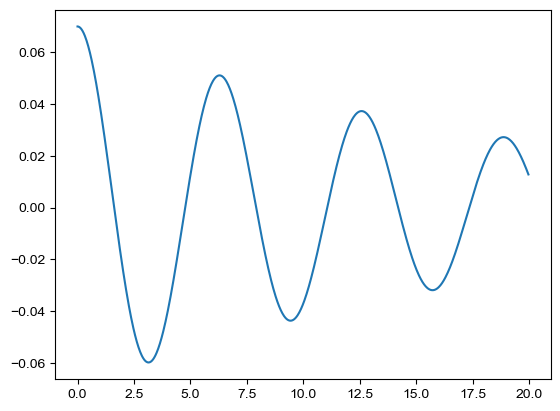

In [4]:
class SpringMassDataset(object):
    '''
    Generate data for spring-mass-damping systems
    '''
    def __init__(self, k, m, A0, c, v0=0, et=20, Nt=800):
        super(SpringMassDataset, self).__init__()
        self.k = k
        self.m = m
        self.A0 = A0
        self.c = c
        self.et = et
        self.v0 = v0
        self.Nt = Nt

        self.omega_n = np.sqrt(k / m)
        self.xi = c / 2 / np.sqrt(m * k)
        self.omega_d = self.omega_n * np.sqrt(1 - self.xi**2)
        self.A = np.sqrt(A0**2 + ((v0 + self.xi * self.omega_n * A0) / self.omega_d)**2)
        self.phi = np.arctan(self.omega_d * A0 / (v0 + self.xi * self.omega_n * A0))

    def solution(self):
        t = np.linspace(0, self.et, self.Nt, endpoint=False)
        x = self.A * np.exp(-self.xi * self.omega_n * t) * np.sin(self.omega_d * t + self.phi)
        info = {'t': t, 'x': x}
        df = pd.DataFrame(info)
        return df
    
k, m, A0, c, et, Nt = 0.2, 0.2, 0.07, 0.02, 20, 1000
dataset = SpringMassDataset(k, m, A0, c)
data_old = dataset.solution()
fig = plt.figure()
plt.plot(data_old['t'], data_old['x'])